In [14]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from pyHalo.PresetModels.cdm import CDM
from pyHalo.realization_extensions import RealizationExtensions
from lenstronomy.LensModel.lens_model import LensModel

## Adding a population of globular clusters to a population of CDM halos

In [15]:
zlens, zsource = 0.5, 2.0
cone_opening_angle_arcsec = 6.0
realizationCDM = CDM(zlens, zsource, LOS_normalization=1.0, sigma_sub=0.1, 
                     cone_opening_angle_arcsec=cone_opening_angle_arcsec,
                    log_mlow=7.0)
kwargs_mass_sheet={'log_mlow_sheets': 7.0, 'kappa_scale_subhalos': 0.1}
lens_model_list_halos, lens_redshift_array_halos, kwargs_halos, _ = realizationCDM.lensing_quantities(kwargs_mass_sheet=kwargs_mass_sheet)
print('number of halos: ', len(realizationCDM.halos))

number of halos:  1740


The GCs have a log-normal mass function with mean log10_mgc_mean and standard deviation log10_mgc_sigma. 

The fraction of mass contained GCs inside 8 * Re is assumed to be f * m_host, where m_host is the mass of the host halo, and Re is the galaxy half-light radius (Forbes et al. https://arxiv.org/pdf/1602.01105). The default is f = 3.4*10^-5 

The mass profile for the GCs is 
\begin{equation}
\rho\left(r, r_c, \gamma\right) = \rho_0 \left(1+r^2/r_c^2\right)^{-\gamma/2}
\end{equation}

The mass is related to a length scale $l_{\rm{gc}}$
\begin{equation}
l_{\rm{gc}} = l_{\rm{gc,0}}\left(m /10^5\right)^{1/3}
\end{equation}

The mass is the total mass in 3D inside a sphere with radius $l_{\rm{gc}}$, and the core size is related to $l_{\rm{gc}}$ through an additional parameter r_core_fraction, r_core_fraction $ \times l_{\rm{gc}} = r_c$. 

In summary the parameters that describe the shape of the GC mass function are log10_mgc_mean and log10_mgc_sigma. 

The parameters that describe the abundance per unit mass in GCs are Re (galaxy effective radius) f (fraction of mass relative to m_host) and m_host. 

The parameters that describe the density profile are $l_{\rm{gc,0}}$, $\gamma$, and r_core_fraction 

In [29]:
ext = RealizationExtensions(realizationCDM)
log10_mgc_mean = 5.0
log10_mgc_sigma = 0.5
rendering_radius_arcsec = 0.2
galaxy_Re = 6.0 # kpc
center_x = [1.0, 0.0, -1.0, 0.0]
center_y = [0.0, 1.0, 0.0, -1.0]
f = 3.4e-5 
host_halo_mass = 10 ** 13.3

gamma_gc = 2.5
gc_size_lightyear = 100
r_core_fraction = 0.05

gc_profile_args = {'gamma': gamma_gc, 'gc_size_lightyear': gc_size_lightyear, 'r_core_fraction': r_core_fraction}
realizationCDM_with_GCs = ext.add_globular_clusters(log10_mgc_mean,
                                         log10_mgc_sigma,
                                         rendering_radius_arcsec,
                                         gc_profile_args,
                                         galaxy_Re,
                                         host_halo_mass, 
                                         f,
                                         center_x=center_x,
                                         center_y=center_y)
print('number of GCs: ', len(realizationCDM_with_GCs.halos) - len(realizationCDM.halos))
lens_model_list_gcs, lens_redshift_array_gcs, kwargs_halos_gcs, _ = realizationCDM_with_GCs.lensing_quantities(
    kwargs_mass_sheet=kwargs_mass_sheet
)

number of GCs:  17


In [30]:
kwargs_macromodel = [{'theta_E': 1., 'center_x': 0., 'center_y': 0., 'e1': 0.2, 'e2': -0.1, 'gamma': 2.},
                    {'gamma1': -0.04, 'gamma2': 0.09}]
lens_model_list_macro = ['EPL', 'SHEAR']
lens_model_macro = LensModel(lens_model_list_macro)

lens_model = LensModel(lens_model_list_macro + lens_model_list_halos, lens_redshift_list=[0.5]*2 + list(lens_redshift_array_halos),
                      z_source=2.0, multi_plane=True)
lens_model_gcs = LensModel(lens_model_list_macro + lens_model_list_gcs, lens_redshift_list=[0.5]*2 + list(lens_redshift_array_gcs),
                      z_source=2.0, multi_plane=True)
kwargs = kwargs_macromodel + kwargs_halos
kwargs_gcs = kwargs_macromodel + kwargs_halos_gcs 


In [31]:
npix = 200 
_x = _y = np.linspace(-1.6, 1.6, npix)
xx, yy = np.meshgrid(_x, _y)
shape0 = xx.shape
kappa = lens_model.kappa(xx.ravel(), yy.ravel(), kwargs).reshape(shape0)
kappa_gcs = lens_model_gcs.kappa(xx.ravel(), yy.ravel(), kwargs_gcs).reshape(shape0)
kappa_macro = lens_model_macro.kappa(xx.ravel(), yy.ravel(), kwargs_macromodel).reshape(shape0)

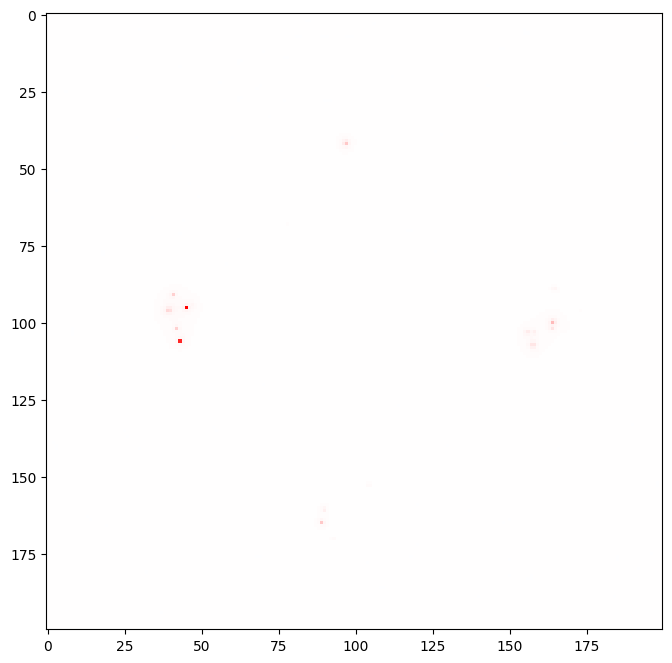

In [36]:
fig = plt.figure(1)
fig.set_size_inches(8,8)

vmin_max = 0.05
cmap = 'bwr'
#plt.scatter(realizationCDM_with_GCs.x, realizationCDM_with_GCs.y)
plt.imshow(kappa_gcs - kappa, vmin=-vmin_max, vmax=vmin_max, cmap=cmap)

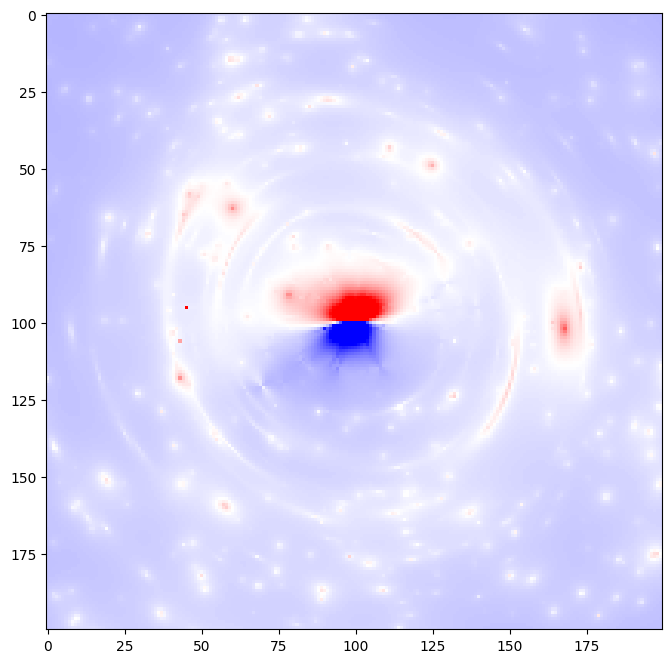

In [37]:
fig = plt.figure(1)
fig.set_size_inches(8,8)

vmin_max = 0.1
cmap = 'bwr'
plt.imshow(kappa_gcs-kappa_macro, vmin=-vmin_max, vmax=vmin_max, cmap=cmap)

In [38]:
_realizationCDM = CDM(zlens, zsource, LOS_normalization=0.0, sigma_sub=0.0, 
                     cone_opening_angle_arcsec=cone_opening_angle_arcsec,
                    log_mlow=6.0)
ext = RealizationExtensions(_realizationCDM)

log10_mgc_mean = 5.0
log10_mgc_sigma = 0.5
rendering_radius_arcsec = 0.2
galaxy_Re = 6.0 # kpc
center_x = [1.0, 0.0, -1.0, 0.0]
center_y = [0.0, 1.0, 0.0, -1.0]
f = 3.4e-5 
host_halo_mass = 10 ** 13.3

gamma_gc = 2.5
gc_size_lightyear = 100
r_core_fraction = 0.05

gc_profile_args = {'gamma': gamma_gc, 
                   'gc_size_lightyear': gc_size_lightyear, 
                   'r_core_fraction': r_core_fraction}

GCs = ext.add_globular_clusters(log10_mgc_mean,
                                         log10_mgc_sigma,
                                         rendering_radius_arcsec,
                                         gc_profile_args,
                                         galaxy_Re,
                                         host_halo_mass, 
                                         f,
                                         center_x=center_x,
                                         center_y=center_y)

In [39]:
rho0 = []

for gc in GCs.halos:
    profile_args = gc.profile_args
    print(profile_args)
    rho0.append(profile_args['rho0'])
rho0 = profile_args['rho0'] # solar masses per kpc^3
rho0_msun_per_pc = rho0 * 1e-9
print(rho0_msun_per_pc)


{'rho0': 359576658526.3615, 'gc_size': 0.03714125511525249, 'gamma': 2.5, 'r_core_arcsec': 0.0018570627557626248}
{'rho0': 359576658526.36145, 'gc_size': 0.02758700024791534, 'gamma': 2.5, 'r_core_arcsec': 0.0013793500123957672}
{'rho0': 359576658526.36176, 'gc_size': 0.012753713436186866, 'gamma': 2.5, 'r_core_arcsec': 0.0006376856718093433}
{'rho0': 359576658526.36176, 'gc_size': 0.044338672051368926, 'gamma': 2.5, 'r_core_arcsec': 0.0022169336025684465}
{'rho0': 359576658526.3619, 'gc_size': 0.04238431806335614, 'gamma': 2.5, 'r_core_arcsec': 0.002119215903167807}
{'rho0': 359576658526.362, 'gc_size': 0.044107985844144264, 'gamma': 2.5, 'r_core_arcsec': 0.002205399292207213}
{'rho0': 359576658526.3618, 'gc_size': 0.04615164116241091, 'gamma': 2.5, 'r_core_arcsec': 0.0023075820581205456}
{'rho0': 359576658526.3614, 'gc_size': 0.0405897498739693, 'gamma': 2.5, 'r_core_arcsec': 0.0020294874936984653}
{'rho0': 359576658526.36163, 'gc_size': 0.02351012172158587, 'gamma': 2.5, 'r_core_arc